<a href="https://colab.research.google.com/github/tannguyen2512/CS_week2_project_scrape_Tiki_categories_products/blob/master/WeeklyProject_Get_Tiki_main_categories_sub_categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crawling Tiki main categories and sub categories

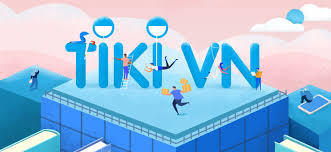

This notebook will guide you to use python function recursively to crawl main categories. For each main categories, it will start to crawl links for sub categories. Recursively, each sub categories have deeper levels of sub categories( Main -> level 2 -> level 3 -> level 4 -> ... ? ) = How deep can it go -> Inception!!!

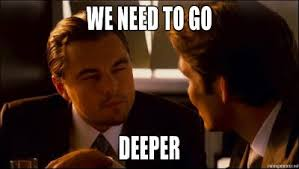

Since we don't know how many level of sub categories and how deep for each categories, we need to use recursion to solve this problem.

All of these category links will be saved in a SQLite database.
After crawling all categories (main and subs), you can use your previous weekly project function to crawl products for each of categories to get to get as many products as possible.

At the end of the day, this notebook only crawl links of categories. Therefore, crawling products is your task for the weekly project.

In [ ]:
# install selenium and other resources for crawling data
!pip install selenium
# install other resources for doing crawling
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (89.0.4389.90-0ubuntu0.18.04.2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from time import sleep
from random import randint
import json
import re
import time

from selenium import webdriver
# Set driver for Chrome
options = webdriver.ChromeOptions()
options.add_argument('-headless') # since we run selenium on Google Colab so we don't want a chrome browser opens, so it will run in the background
options.add_argument('-no-sandbox')

In [ ]:
def get_url(url):
    driver = webdriver.Chrome('chromedriver',options=options)        # Define the chrome drivers with setting options we define above    
    # we let selenium to wait for 30 seconds for all javascript script done before return the result of HTML
    driver.implicitly_wait(30) 
    driver.get(url)                                             # Open the browser again to get web page
    html_data = driver.page_source                                   # After driver.get() is done, you can get back HTML string by using .page_source
    driver.close()                                                   # Close the driver after retrieving the web page
    time.sleep(5)
    soup = BeautifulSoup(html_data, 'html.parser') 

    return soup

In [ ]:
def extract_tiki_info(url):
  """ Extract info from all products of a specfic category on Tiki website
      Input: url
      Output: info of products, saved as list of dictionary. If no products shown, return empty list.
  """
  data = []
  index = 1
  soup = get_url(url)

  # FIND ALL PRODUCT ITEMS
  products = soup.find_all('a', {'class':'product-item'})
  all_script = soup.find_all('script', {'type':'application/ld+json'})
  print("BATCH SIZE:", len(products))

  if (soup.find('div', {'class':'style__StyledNotFoundProductView-sc-1uz0b49-0'})):
    print("END PAGE")
  elif len(products):
    # EXTRACT INFO TO DICTIONARY
    for i in products: 
      d = {'name':'','price':'','product_url':'','image':'', 'product_sku':'',
           'tiki_now':'','freeship':'','review':'','rating':'','under_price':'',
           'discount':'','installment':'','gift':''}
      
      try:
        d['name']         = i.find('div',{'class' : 'name'}).text
        d['price']        = int(re.sub('[. ₫]','', i.find('div',{'class':'price-discount__price'}).text))
        d['product_url']  = 'https://tiki.vn' + i['href'] 
        thumbnail         = i.find('div',{'class':'thumbnail'})
        d['image']        = thumbnail.img['src']        
        d['tiki_now']     = bool(i.find('div',{'class':'badge-service'}).find('div',{'class':'item'})) 
        d['freeship']     = bool(i.find('div',{'class':'badge-top'}).text == "Freeship")
        
        if i.find('div',{'class':'review'}):
          d['review']     = int(i.find('div',{'class':'review'}).text.strip('(').strip(')'))
        else:
          d['review'] = "N/A"
        
        d['under_price']  = bool(i.find('div',{'class':'badge-under-price'}).find('div',{'class':'item'}))

        if i.find('div', {'class':'price-discount__discount'}):
          d['discount']   = int(re.sub('[-%]','', i.find('div',{'class':'price-discount__discount'}).text))
        else:
          d['discount']   = "N/A"
        
        d['installment']  = bool(i.find('div',{'class':'badge-benefits'}).img)
        d['gift']         = bool(i.find('div',{'class':'freegift-list'}))

        script = all_script[index]
        dict_content = json.loads(script.text)
        d['product_sku']  = dict_content['sku']
        
        if 'aggregateRating' in dict_content:
          d['rating']     = float(dict_content['aggregateRating']['ratingValue'])
        else:
          d['rating']     = "N/A"

      except Exception as e:
        print(e)

      index += 1
      data.append(d)
        
  return data

In [ ]:
def scrape_tiki(base_url):
  result = []
  page_number = 1
  main, opt = base_url.split('?')
  
  while True:
    page = f'?page={page_number}&'
    url = main+page+opt
    print("url =", url)
    data = extract_tiki_info(url)
    if len(data)>0:
      result.extend(data)
    else:
      break
    if page_number == 2:
      break
    page_number += 1
    sleep(randint(1,2))

  print("****TOTAL = ",len(result))

  items = pd.DataFrame(data = result, columns = result[0].keys())
  items.to_csv("/content/gdrive/MyDrive/result2.csv", index=False)

# Function to do CRUD (create/ read/ update/ delete) on database

In [ ]:
import sqlite3

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
PATH_TO_DB = '/content/gdrive/MyDrive/'
conn = sqlite3.connect(PATH_TO_DB+'tiki.db')
cur = conn.cursor()

In [ ]:
# Create table categories in the database using a function
def create_categories_table():
    query = """
        CREATE TABLE IF NOT EXISTS categories (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name VARCHAR(255),
            url TEXT, 
            parent_id INTEGER, 
            create_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
    """
    try:
        cur.execute(query)
        conn.commit()
    except Exception as err:
        print('ERROR BY CREATE TABLE', err)
        
create_categories_table()

In [ ]:
def select_query(query,conn=conn):
    return pd.read_sql_query(query, conn)

In [ ]:
# Insert a row of data to the table categories
query = """
    INSERT INTO categories (name, url, parent_id)
    VALUES (?, ?, ?);
"""

# query="""
#     DELETE FROM categories WHERE id=1;
# """

val = ('Phone','phone.xyz', 5)

try:
    cur.execute(query, val)
    cat_id = cur.lastrowid
    print(cat_id)
    conn.commit()

except Exception as err:
    print('ERROR BY INSERT:', err)

182


In [ ]:
select_query('SELECT * FROM categories')

id                        name  ... parent_id            create_at
0        1  Điện Thoại - Máy Tính Bảng  ...       NaN  2021-04-09 17:43:28
1        2         Điện Tử - Điện Lạnh  ...       NaN  2021-04-09 17:43:28
2        3      Phụ Kiện - Thiết Bị Số  ...       NaN  2021-04-09 17:43:28
3        4        Laptop - Thiết bị IT  ...       NaN  2021-04-09 17:43:28
4        5         Máy Ảnh - Quay Phim  ...       NaN  2021-04-09 17:43:28
...    ...                         ...  ...       ...                  ...
2774  2775                    Phấn nén  ...    2630.0  2021-04-10 01:33:23
2775  2776                    Phấn bột  ...    2630.0  2021-04-10 01:33:23
2776  2777                    Dạng bút  ...    2643.0  2021-04-10 01:36:15
2777  2778                   Dạng nước  ...    2643.0  2021-04-10 01:36:15
2778  2779                    Dạng gel  ...    2643.0  2021-04-10 01:36:15

[2779 rows x 5 columns]

In [ ]:
# drop the whole table to clean things up
cur.execute('DROP TABLE categories;')
conn.commit()

In [ ]:
# re-create our category table again
create_categories_table()
select_query('SELECT * FROM categories')

Empty DataFrame
Columns: [id, name, url, parent_id, create_at]
Index: []

# OOP to do CRUD (create/ read/ update/ delete) on database

In [ ]:
# Instead of using a function to do CRUD on database,
# creating a class Category is preferred
# attributes: name, url, parent_id
# instance method: save_into_db()
class Category:
    def __init__(self, name, url, parent_id=None, cat_id=None):
        self.cat_id = cat_id
        self.name = name
        self.url = url
        self.parent_id = parent_id

    def __repr__(self):
        return f"ID: {self.cat_id}, Name: {self.name}, URL: {self.url}, Parent: {self.parent_id}"

    def save_into_db(self):
        query = """
            INSERT INTO categories (name, url, parent_id)
            VALUES (?, ?, ?);
        """
        val = (self.name, self.url, self.parent_id)
        try:
            cur.execute(query, val)
            self.cat_id = cur.lastrowid
            conn.commit()
        except Exception as err:
            print('ERROR BY INSERT:', err)


# Get main categories

In [ ]:
# empty our category set
CATEGORY_SET = set()

In [ ]:
def can_add_to_cat_set(cat_name,save=False):
  if cat_name not in CATEGORY_SET:
    if save:
      CATEGORY_SET.add(cat_name)
      print(f'Added "{cat_name}" to CATEGORY_SET')
    return True
  return False


In [ ]:
main_categories = [{'Name': 'Điện Thoại - Máy Tính Bảng', 'URL': 'https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner'},
{'Name': 'Điện Tử - Điện Lạnh', 'URL': 'https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner'}, 
{'Name': 'Phụ Kiện - Thiết Bị Số', 'URL': 'https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner'},
{'Name': 'Laptop - Thiết bị IT', 'URL': 'https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner'},
{'Name': 'Máy Ảnh - Quay Phim', 'URL': 'https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner'}, 
{'Name': 'Điện Gia Dụng', 'URL': 'https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner'}, 
{'Name': 'Nhà Cửa Đời Sống', 'URL': 'https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner'}, 
{'Name': 'Hàng Tiêu Dùng - Thực Phẩm', 'URL': 'https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner'}, 
{'Name': 'Đồ chơi, Mẹ & Bé', 'URL': 'https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner'}, 
{'Name': 'Làm Đẹp - Sức Khỏe', 'URL': 'https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner'},
{'Name': 'Thể Thao - Dã Ngoại', 'URL': 'https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner'},
{'Name': 'Xe Máy, Ô tô, Xe Đạp', 'URL': 'https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner'},
{'Name': 'Hàng quốc tế', 'URL': 'https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner'}, 
{'Name': 'Sách, VPP & Quà Tặng', 'URL': 'https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner'}, 
{'Name': 'Voucher - Dịch Vụ - Thẻ Cào', 'URL': 'https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner'}]

In [ ]:
def get_main_category(main_categories,save_db=False):
    result=[]
    for i in main_categories:
        _=can_add_to_cat_set(i['Name'],save_db)

        main_cat = Category(i['Name'],i['URL'])
        if save_db:
            main_cat.save_into_db()
        result.append(main_cat)
    return result

In [ ]:
main_cat_objs = get_main_category(main_categories,save_db=True)

Added "Điện Thoại - Máy Tính Bảng" to CATEGORY_SET
Added "Điện Tử - Điện Lạnh" to CATEGORY_SET
Added "Phụ Kiện - Thiết Bị Số" to CATEGORY_SET
Added "Laptop - Thiết bị IT" to CATEGORY_SET
Added "Máy Ảnh - Quay Phim" to CATEGORY_SET
Added "Điện Gia Dụng" to CATEGORY_SET
Added "Nhà Cửa Đời Sống" to CATEGORY_SET
Added "Hàng Tiêu Dùng - Thực Phẩm" to CATEGORY_SET
Added "Đồ chơi, Mẹ & Bé" to CATEGORY_SET
Added "Làm Đẹp - Sức Khỏe" to CATEGORY_SET
Added "Thể Thao - Dã Ngoại" to CATEGORY_SET
Added "Xe Máy, Ô tô, Xe Đạp" to CATEGORY_SET
Added "Hàng quốc tế" to CATEGORY_SET
Added "Sách, VPP & Quà Tặng" to CATEGORY_SET
Added "Voucher - Dịch Vụ - Thẻ Cào" to CATEGORY_SET


In [ ]:
select_query('SELECT * FROM CATEGORIES')

id                        name  ... parent_id            create_at
0        1  Điện Thoại - Máy Tính Bảng  ...       NaN  2021-04-09 17:43:28
1        2         Điện Tử - Điện Lạnh  ...       NaN  2021-04-09 17:43:28
2        3      Phụ Kiện - Thiết Bị Số  ...       NaN  2021-04-09 17:43:28
3        4        Laptop - Thiết bị IT  ...       NaN  2021-04-09 17:43:28
4        5         Máy Ảnh - Quay Phim  ...       NaN  2021-04-09 17:43:28
...    ...                         ...  ...       ...                  ...
2774  2775                    Phấn nén  ...    2630.0  2021-04-10 01:33:23
2775  2776                    Phấn bột  ...    2630.0  2021-04-10 01:33:23
2776  2777                    Dạng bút  ...    2643.0  2021-04-10 01:36:15
2777  2778                   Dạng nước  ...    2643.0  2021-04-10 01:36:15
2778  2779                    Dạng gel  ...    2643.0  2021-04-10 01:36:15

[2779 rows x 5 columns]

# Get sub categories

In [ ]:
import re

# get_sub_categories() given a parent category
def get_sub_categories(parent_category, save_db=False):
    parent_url = parent_category.url
    result = []

    try:
        soup = get_url(parent_url)
        with open('test','w') as checksoup:
            checksoup.write(soup.prettify())
        for a in soup.find_all('a', {'class':'item item--category'}):
            name = a.text.strip()
            if can_add_to_cat_set(name,save_db): 
                sub_url = a['href']
                cat = Category(name, sub_url, parent_category.cat_id) # we now have parent_id, which is cat_id of parent category
                if save_db:
                  cat.save_into_db()
                result.append(cat)
    except Exception as err:
        print('ERROR IN GETTING SUB CATEGORIES:', err)
    return result

In [ ]:
main_cat_objs[0]

ID: 1, Name: Điện Thoại - Máy Tính Bảng, URL: https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner, Parent: None

In [ ]:
tmp= get_sub_categories(main_cat_objs[0], save_db=False)
tmp

[ID: None, Name: Điện thoại Smartphone, URL: https://tiki.vn/dien-thoai-smartphone/c1795?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: None, Name: Điện thoại phổ thông, URL: https://tiki.vn/dien-thoai-pho-thong/c1796?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: None, Name: Điện thoại bàn, URL: https://tiki.vn/dien-thoai-ban/c8061?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: None, Name: Máy đọc sách, URL: https://tiki.vn/may-doc-sach/c28856?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: None, Name: Máy tính bảng, URL: https://tiki.vn/may-tinh-bang/c1794?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1]

In [ ]:
select_query('SELECT * FROM categories')

id                         name  \
0    1   Điện Thoại - Máy Tính Bảng   
1    2          Điện Tử - Điện Lạnh   
2    3       Phụ Kiện - Thiết Bị Số   
3    4         Laptop - Thiết bị IT   
4    5          Máy Ảnh - Quay Phim   
5    6                Điện Gia Dụng   
6    7             Nhà Cửa Đời Sống   
7    8   Hàng Tiêu Dùng - Thực Phẩm   
8    9             Đồ chơi, Mẹ & Bé   
9   10           Làm Đẹp - Sức Khỏe   
10  11          Thể Thao - Dã Ngoại   
11  12         Xe Máy, Ô tô, Xe Đạp   
12  13                 Hàng quốc tế   
13  14         Sách, VPP & Quà Tặng   
14  15  Voucher - Dịch Vụ - Thẻ Cào   
15  16        Điện thoại Smartphone   
16  17         Điện thoại phổ thông   
17  18               Điện thoại bàn   
18  19                 Máy đọc sách   
19  20                Máy tính bảng   

                                                  url  parent_id  \
0   https://tiki.vn/dien-thoai-may-tinh-bang/c1789...        NaN   
1   https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?...        NaN   
2   https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815...        NaN   
3   https://tiki.vn/laptop-may-vi-tinh/c1846?src=c...        NaN   
4   https://tiki.vn/may-anh/c1801?src=c.1801.hambu...        NaN   
5   https://tiki.vn/dien-gia-dung/c1882?src=c.1882...        NaN   
6   https://tiki.vn/nha-cua-doi-song/c1883?src=c.1...        NaN   
7   https://tiki.vn/bach-hoa-online/c4384?src=c.43...        NaN   
8   https://tiki.vn/me-va-be/c2549?src=c.2549.hamb...        NaN   
9   https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1...        NaN   
10  https://tiki.vn/the-thao/c1975?src=c.1975.hamb...        NaN   
11  https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c...        NaN   
12  https://tiki.vn/hang-quoc-te/c17166?src=c.1716...        NaN   
13  https://tiki.vn/nha-sach-tiki/c8322?src=c.8322...        NaN   
14  https://tiki.vn/voucher-dich-vu/c11312?src=c.1...        NaN   
15  https://tiki.vn/dien-thoai-smartphone/c1795?sr...        1.0   
16  https://tiki.vn/dien-thoai-pho-thong/c1796?src...        1.0   
17  https://tiki.vn/dien-thoai-ban/c8061?src=c.178...        1.0   
18  https://tiki.vn/may-doc-sach/c28856?src=c.1789...        1.0   
19  https://tiki.vn/may-tinh-bang/c1794?src=c.1789...        1.0   

              create_at  
0   2021-04-09 17:36:55  
1   2021-04-09 17:36:55  
2   2021-04-09 17:36:55  
3   2021-04-09 17:36:55  
4   2021-04-09 17:36:55  
5   2021-04-09 17:36:55  
6   2021-04-09 17:36:55  
7   2021-04-09 17:36:55  
8   2021-04-09 17:36:55  
9   2021-04-09 17:36:55  
10  2021-04-09 17:36:55  
11  2021-04-09 17:36:56  
12  2021-04-09 17:36:56  
13  2021-04-09 17:36:56  
14  2021-04-09 17:36:56  
15  2021-04-09 17:37:38  
16  2021-04-09 17:37:38  
17  2021-04-09 17:37:38  
18  2021-04-09 17:37:39  
19  2021-04-09 17:37:39

# Put everything together

In [ ]:
# drop the whole table to clean things up
cur.execute('DROP TABLE categories;')
conn.commit()

# re-create our category table again
create_categories_table()

# empty our category set
CATEGORY_SET= set()

# double check
select_query('SELECT * FROM categories')

Empty DataFrame
Columns: [id, name, url, parent_id, create_at]
Index: []

In [ ]:
# get_all_categories() given a list of main categories (This is a recursion function)
# def get_all_categories(categories,save_db):
#     # if I reach the last possible category, I need to stop
#     if len(categories) == 0:
#         return      
#     for cat in categories:
#         print(f'Getting {cat} sub-categories...')
#         sub_categories = get_sub_categories(cat, save_db=save_db)
#         print(f'Finished! {cat.name} has {len(sub_categories)} sub-categories')
#         get_all_categories(sub_categories,save_db=save_db)

In [ ]:
def get_all_categories(categories,save_db):
    categories = categories.copy()
    while len(categories):
        cat_to_crawl = categories[0]
        print(f'Getting {cat_to_crawl} sub-categories...')
        sub_categories = get_sub_categories(cat_to_crawl, save_db=save_db)
        print(f'Finished! {cat_to_crawl.name} has {len(sub_categories)} sub-categories')
        categories+=sub_categories
        del categories[0]

In [ ]:
main_cat_objs = get_main_category(main_categories,save_db=True)
main_cat_objs

Added "Điện Thoại - Máy Tính Bảng" to CATEGORY_SET
Added "Điện Tử - Điện Lạnh" to CATEGORY_SET
Added "Phụ Kiện - Thiết Bị Số" to CATEGORY_SET
Added "Laptop - Thiết bị IT" to CATEGORY_SET
Added "Máy Ảnh - Quay Phim" to CATEGORY_SET
Added "Điện Gia Dụng" to CATEGORY_SET
Added "Nhà Cửa Đời Sống" to CATEGORY_SET
Added "Hàng Tiêu Dùng - Thực Phẩm" to CATEGORY_SET
Added "Đồ chơi, Mẹ & Bé" to CATEGORY_SET
Added "Làm Đẹp - Sức Khỏe" to CATEGORY_SET
Added "Thể Thao - Dã Ngoại" to CATEGORY_SET
Added "Xe Máy, Ô tô, Xe Đạp" to CATEGORY_SET
Added "Hàng quốc tế" to CATEGORY_SET
Added "Sách, VPP & Quà Tặng" to CATEGORY_SET
Added "Voucher - Dịch Vụ - Thẻ Cào" to CATEGORY_SET


[ID: 1, Name: Điện Thoại - Máy Tính Bảng, URL: https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner, Parent: None,
 ID: 2, Name: Điện Tử - Điện Lạnh, URL: https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner, Parent: None,
 ID: 3, Name: Phụ Kiện - Thiết Bị Số, URL: https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner, Parent: None,
 ID: 4, Name: Laptop - Thiết bị IT, URL: https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner, Parent: None,
 ID: 5, Name: Máy Ảnh - Quay Phim, URL: https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner, Parent: None,
 ID: 6, Name: Điện Gia Dụng, URL: https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner, Parent: None,
 ID: 7, Name: Nhà Cửa Đời Sống, URL: https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner, Parent: None,
 ID: 8, Name: Hàng Tiêu Dùng - Thực Phẩm

In [ ]:
get_all_categories(main_cat_objs,save_db=True)

Getting ID: 1, Name: Điện Thoại - Máy Tính Bảng, URL: https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner, Parent: None sub-categories...
Added "Điện thoại Smartphone" to CATEGORY_SET
Added "Điện thoại phổ thông" to CATEGORY_SET
Added "Điện thoại bàn" to CATEGORY_SET
Added "Máy đọc sách" to CATEGORY_SET
Added "Máy tính bảng" to CATEGORY_SET
Finished! Điện Thoại - Máy Tính Bảng has 5 sub-categories
Getting ID: 2, Name: Điện Tử - Điện Lạnh, URL: https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner, Parent: None sub-categories...
Added "Âm thanh & Phụ kiện Tivi" to CATEGORY_SET
Added "Tủ lạnh" to CATEGORY_SET
Added "Máy lạnh - Máy điều hòa" to CATEGORY_SET
Added "Máy giặt" to CATEGORY_SET
Added "Tủ đông - Tủ mát" to CATEGORY_SET
Added "Phụ kiện điện lạnh" to CATEGORY_SET
Added "Tivi" to CATEGORY_SET
Added "Máy nước nóng" to CATEGORY_SET
Added "Máy rửa chén" to CATEGORY_SET
Added "Máy sấy quần áo" to CATEGORY_SET
Added "

In [ ]:
select_query('SELECT COUNT(*) FROM categories')

COUNT(*)
0      2779

In [ ]:
select_query('SELECT * FROM categories ORDER BY ID DESC LIMIT 5')

id       name                                                url  \
0  2779   Dạng gel  https://tiki.vn/dang-gel/c11785?src=c.1520.ham...   
1  2778  Dạng nước  https://tiki.vn/dang-nuoc/c11787?src=c.1520.ha...   
2  2777   Dạng bút  https://tiki.vn/dang-but/c11789?src=c.1520.ham...   
3  2776   Phấn bột  https://tiki.vn/phan-bot/c11773?src=c.1520.ham...   
4  2775   Phấn nén  https://tiki.vn/phan-nen/c11771?src=c.1520.ham...   

   parent_id            create_at  
0       2643  2021-04-10 01:36:15  
1       2643  2021-04-10 01:36:15  
2       2643  2021-04-10 01:36:15  
3       2630  2021-04-10 01:33:23  
4       2630  2021-04-10 01:33:23

In [ ]:
lowest_cats = select_query('''
  SELECT DISTINCT id, url
  FROM categories 
    WHERE id IN (
        SELECT DISTINCT id 
        FROM categories 
        
        EXCEPT 
        
        SELECT DISTINCT parent_id 
        FROM categories
        ) 
    ORDER BY id DESC''')

In [ ]:
select_query('SELECT COUNT(*) FROM (SELECT * FROM categories WHERE id IN (SELECT DISTINCT id FROM categories EXCEPT SELECT DISTINCT parent_id FROM categories))')

COUNT(*)
0      2302

In [ ]:
number_catagory = int(lowest_cats.shape[0]/2)
for i in range(0,number_catagory):
  row = lowest_cats.iloc[i,:]
  category_id = row['id']
  cat_url = row['url']
  scrape_tiki(cat_url)
  with open('/content/gdrive/MyDrive/result2.csv','r') as dataFile :
    data = pd.read_csv(dataFile)
    # print(type(data))
    for n in range(len(data)):
      # print(data.iloc[n,:])
      item = Product(data.iloc[n,:],category_id)
      item.save_into_db()


url = https://tiki.vn/dang-gel/c11785?page=1&src=c.1520.hamburger_menu_fly_out_banner
BATCH SIZE: 23
url = https://tiki.vn/dang-gel/c11785?page=2&src=c.1520.hamburger_menu_fly_out_banner
BATCH SIZE: 0
END PAGE
****TOTAL =  23
url = https://tiki.vn/dang-nuoc/c11787?page=1&src=c.1520.hamburger_menu_fly_out_banner
BATCH SIZE: 33
url = https://tiki.vn/dang-nuoc/c11787?page=2&src=c.1520.hamburger_menu_fly_out_banner
BATCH SIZE: 0
END PAGE
****TOTAL =  33
url = https://tiki.vn/dang-but/c11789?page=1&src=c.1520.hamburger_menu_fly_out_banner
BATCH SIZE: 48
url = https://tiki.vn/dang-but/c11789?page=2&src=c.1520.hamburger_menu_fly_out_banner


KeyboardInterrupt: ignored

In [ ]:
select_query('SELECT * FROM products')

Empty DataFrame
Columns: [product_sku, name, price, category_id, product_url, image, tiki_now, freeship, review, rating, under_price, discount, installment, gift, create_at]
Index: []

# Class Product

In [ ]:
# Create table products in the database using a function
def create_products_table():
    query = """
        CREATE TABLE IF NOT EXISTS products (
            product_sku INTERGER PRIMARY KEY,
            name TEXT,
            price INTEGER,
            category_id INTEGER,
            product_url TEXT,
            image TEXT,
            tiki_now INTEGER,
            freeship INTEGER,
            review INTEGER,
            rating REAL,
            under_price INTEGER,
            discount INTEGER,
            installment INTEGER, 
            gift INTEGER,
            create_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
    """
    try:
        cur.execute(query)
        conn.commit()
    except Exception as err:
        print('ERROR BY CREATE TABLE', err)

In [ ]:
create_products_table()
select_query('SELECT * FROM products')

Empty DataFrame
Columns: [product_sku, name, price, category_id, product_url, image, tiki_now, freeship, review, rating, under_price, discount, installment, gift, create_at]
Index: []

In [ ]:
class Product():
    def __init__(self, product, cat_id ) :
        # because extract_tiki_info return a dictionary, for each product, containing all product information
        # so the type of input arguments when creating Product instance is dictionary
        info = ['name','price''product_url','image', 'product_sku',
               'tiki_now','freeship','review','rating','under_price',
               'discount','installment','gift']
        self.name = product['name']
        self.price = int(product['price'])
        self.product_url = product['product_url']
        self.image = product['image']
        self.product_sku = int(product['product_sku'])
        self.tiki_now = int(product['tiki_now'])
        self.freeship = int(product['freeship'])
        self.review = float(product['review'])
        self.rating = float(product['rating'])
        self.under_price = int(product['under_price'])
        self.discount = 0 if product['discount'] == 'NaN' else float(product['discount'])
        self.installment = int(product['installment'])
        self.gift = int(product['gift'])
        self.cat_id = int(cat_id)
    
    def __repr__(self) :
        return f'SKU: {self.product_sku}\t Name: {self.name[:20]}...\t Price: {self.price} VND'

    def save_into_db(self):
        query = """
            INSERT INTO products (product_sku,
                name,
                price,
                category_id,
                product_url,
                image,
                tiki_now,
                freeship,
                review,
                rating,
                under_price,
                discount,
                installment, 
                gift)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
        """
        val = (self.product_sku, self.name, 
                self.price, self.cat_id,
                self.product_url, self.image,
                self.tiki_now, self.freeship,
                self.review, self.rating,
                self.under_price, self.discount,
                self.installment, self.gift)
        try:
            cur.execute(query, val)
            conn.commit()
        except Exception as err:
            print('ERROR BY INSERT:', err)

In [ ]:
cur.execute('DROP TABLE products;')
conn.commit()

# Be aware of duplicated products

A problem: you will have duplicated products if you start collecting product data at higher level categories

To get the product, we need to get the lowest level categories and start crawling from those urls, which means those categories (lowest level/layer) doesn't have any sub category. In other words, they will not be the parent category of any other sub category

Hint: Can you write a LEFT JOIN sql query to get all sub category for each category? How can you filter out lowest layer categories using this sql query?


| ID | Name   | URL | Parent_ID |
|------|------|-----|---------- |
|  1 | Cat1 | 1.com | None      |
| 2 | Cat2 | 2.com | 1 |
| 3 | Cat3 | 3.com | 1 |
| 4 | Cat4 | 4.com | 3 |


# Guidelines

This weekly project might be a little tougher than usual, as you have to have a clear workflow and how to organize your functions. So here is an example workflow you can follow:

- Step 1: Build and fill your Category table using example code in the notebook

- Step 2: Create a function to get the list of URLs of lowest layer categories (This list can have +2000 categories)

- Step 3: Break this list into smaller sublists (using python slicing). 
By doing this, it's easier to assign tasks to your teammates: each member can take care of a portion of the list. 
Also you don't want to let your computer run a loop through 1 single list. If it crashes and you don't have a caching mechanism, you will lose all your work!

- Step 4: For each category URL of a sublist, crawl all the products per page (**recommended number of pages to crawl: 2 pages per category**, but feel free to go for more) and save them into your PRODUCT table

- Step 5: Use SQL to extract useful information out of this dataset you just collected. For example, what is the most expensive item for each categories? Which catogory contains the most items? Which category/product has the highest reviews or ratings ...? This kind of analysis will help you prepare for next week material: Data Module with Nhan!


Note: You might want to store Product_ID or Category_ID of the last crawled item, so that if your computer crashes and you have to start over again, you can start from these IDs instead of starting from scratch.

And make sure to put sleep() when you crawl, otherwise you will crash very often as Tiki will try to block your IP.